In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
# Please run this cell first to import the necessary libraries.

In [2]:
IMG_SIZE = 128

def preprocess_input(image, target):
    # Resize grayscale input
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    # Resize target color image
    target = tf.image.resize(target, (IMG_SIZE, IMG_SIZE))
    return image, target

# Load CIFAR-10
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Convert to grayscale
x_train_gray = tf.image.rgb_to_grayscale(x_train)
x_test_gray = tf.image.rgb_to_grayscale(x_test)

# Build tf.data pipelines
train_ds = tf.data.Dataset.from_tensor_slices((x_train_gray, x_train))
train_ds = train_ds.map(preprocess_input).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test_gray, x_test))
test_ds = test_ds.map(preprocess_input).batch(32).prefetch(tf.data.AUTOTUNE)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [9]:
# Simulate conditional hints
def add_random_hint(grayscale, color):
    """
    Returns:
    input_with_hint: (H,W,3) -> grayscale + mask + color_hint
    """
    H, W, _ = color.shape
    mask = np.zeros((H, W, 1), dtype=np.float32)
    hint = np.zeros_like(color, dtype=np.float32)

    # Random rectangle as hint region
    h_start = np.random.randint(0, H//2)
    h_end = h_start + np.random.randint(H//4, H//2)
    w_start = np.random.randint(0, W//2)
    w_end = w_start + np.random.randint(W//4, W//2)

    mask[h_start:h_end, w_start:w_end, 0] = 1.0
    hint[h_start:h_end, w_start:w_end, :] = color[h_start:h_end, w_start:w_end, :]

    # Concatenate grayscale + mask + hint
    input_with_hint = np.concatenate([grayscale, mask, hint], axis=-1)
    return input_with_hint

# Apply to train/test datasets
x_train_input = np.array([add_random_hint(x_train_gray[i], x_train[i]) for i in range(len(x_train_gray))])
x_test_input = np.array([add_random_hint(x_test_gray[i], x_test[i]) for i in range(len(x_test_gray))])

# New input shape for model
input_shape = x_train_input.shape[1:]  # (128,128,5)

In [10]:
inputs = Input(shape=input_shape)


x = Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
outputs = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)


model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')

In [11]:
model.fit(x_train_input, x_train, validation_data=(x_test_input, x_test), epochs=10, batch_size=32)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 0.0098 - val_loss: 0.0055
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 9/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 10/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.0043 - val_loss: 0.0042


In [13]:
# Save model
model.save("/content/drive/MyDrive/08_condition_color/colorizer_model.h5")

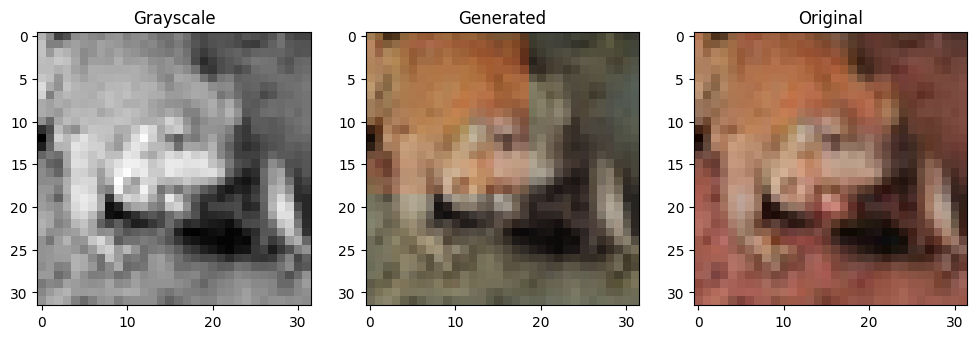

In [15]:
# Convert to NumPy for plotting
grayscale_np = grayscale.numpy()  # shape (32,32,1)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Grayscale")
plt.imshow(np.squeeze(grayscale_np), cmap='gray')  # now works

plt.subplot(1,3,2)
plt.title("Generated")
plt.imshow(colorized[0])

plt.subplot(1,3,3)
plt.title("Original")
plt.imshow(x_test[idx])
plt.show()
